## **Name:** Kevin Lam

## **Computing ID:** bkg8jy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

!pip install lime
from lime import lime_tabular
from sklearn.inspection import permutation_importance

# Below is a new package needed for this lab
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6a74a8d5802514f29d6cbd3cfedbf8d31602aa7f16bf5a36fb9e1802b47eb814
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Lab 3: Decision Trees and Random Forests (100 Points)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/17jL6-gLQWYkZJZGzAduIlU4YET0u2Ek-?usp=sharing)

The goal of this lab is to optimize Decision Tree and Random Forest models using the provided dataset on census level data. Your goal is to build a Random Forest Classifier to be able to predict income levels above or below 50k.

The guidance this week is less prescriptive in terms of steps, so use the skills you have gained over the semester to build and evaluate your models. You will be graded on your model building, interpretation of the results and explanation of model selection. As always, you are welcome to rely on your classmates but submit your own code. Lastly, there are likely several correct approaches involving a variety of different conclusions, just make sure your conclusions are supported by your approach.


The dataset should be familiar as it's the census data, on 48,000+ individuals with a variety of variables and a target variable for above or below 50k in salary.

![](https://www.coopercenter.org/sites/default/files/styles/wide/public/wordpress_import/Figure1CesnsuBlog2-1024x512_0.png?itok=DwYqkfFm)

Look through the data dictionary at its source link: https://archive.ics.uci.edu/ml/datasets/Adult

# **Part 1: Data Preparation and EDA (15 points)**

In a text cell, answer the following exploratory questions and support your observations with any code, if needed.

## **Question 1 (2 points):**
## Read in the features (X) as a Pandas DataFrame. Show the first 5 rows of the features. How many rows do you have?



In [ ]:
# Fetch dataset
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets

In [ ]:
X = pd.DataFrame(X)
X.head()

# there are 5 rows printed

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


**There is a total of** 48842 rows and 14 features (columns)



## **Question 2 (2 points):**
## Are there any potential issues in the data or target that need to be corrected? Why are they issues? What specific method would you use to correct them and why?

## Consider using code and reading the data description (https://archive.ics.uci.edu/dataset/2/adult) to explore:

*   Assumptions and ranges of collected data
*   Missing values (impute? drop?)
*   Numerical data types represented as strings
*   Encoding categorical data appropriately
*   Normalization
*   Standardization

## You will not need to consider feature imbalances or sampling in part 1 or 2 of the lab.

In [ ]:
print(X.info())
print(X.describe())
print(X.describe(include='object'))
print(X.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB
None
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48

**Potential Issues:** Potential issues I've identified are that some features have missing values (denoted by ‘?’), which can skew the model if left unhandled. I also saw that certain numeric columns are stored as strings, and the categorical features need proper encoding for the model to interpret them correctly.


## **Question 3 (6 points):**
## Preprocess the data according to the issues and correction methods you've identified. Save the new features and target variable (if necessary) as X_clean and y_clean.

In [ ]:
X = adult.data.features.copy()
y = adult.data.targets.copy()

# replace '?' with NaN
X.replace('?', np.nan, inplace=True)

# drop missing values and align y
X.dropna(inplace=True)
y = y.loc[X.index]

# convert numerical to float
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X[numeric_cols] = X[numeric_cols].astype(float)
print(X.dtypes)

# 0ne-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)
print("\nEncoded shape:", X_encoded.shape)

X_clean = X_encoded.copy()
y_clean = y.copy()

# remove extra spaces, trailing periods, etc.
y_clean = y_clean.squeeze().str.strip().str.replace('.', '', regex=False)
print(y_clean.value_counts())

age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
dtype: object

Encoded shape: (45222, 96)
income
<=50K    34014
>50K     11208
Name: count, dtype: int64


## **Question 4 (5 points):**
## Create 2 versions of y_clean to create a new target response of whether income is above or below $50,000 for classification.

1.   **y_clean_binary:** Recode y_clean to be 1 if the target is over or equal to
2.   **y_clean_string:** Recode y_clean to be "Above or Equal" if the target is over or equal to 50,000 and "Below" if under.



In [ ]:
# 1 if income is >50K, else 0
y_clean_binary = (y_clean == '>50K').astype(int)

# mapping from binary to labels
y_clean_string = y_clean_binary.replace({1: 'Above or Equal', 0: 'Below'})

y_clean_binary.value_counts()

,count
income,
0,34014
1,11208


In [ ]:
y_clean_string.value_counts()

,count
income,
Below,34014
Above or Equal,11208


# **Part 2: Decision Tree Pruning, Tuning and Evaluation (30 Points)**

## **Question 1 (5 points):**
## Create a function to take in a feature variable (X) and (y). In this function, create a train test split with a random seed of 3001.

## Use a vanilla decision tree model to fit the model on the train set and predict on the test set. Print the precision, recall, and accuracy of the model after prediction.

## Test that your function runs on both y_clean_binary and y_clean_string. For any of the following questions, you may use whichever y_clean variable you'd like.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

def decision_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001, stratify=y)

    clf = DecisionTreeClassifier(random_state=3001)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    average_method = 'binary' if np.issubdtype(y_train.dtype, np.number) else 'macro'

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average_method, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average_method, zero_division=0)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")

print("y_clean_binary:")
decision_tree(X_clean, y_clean_binary)

print("\ny_clean_string:")
decision_tree(X_clean, y_clean_string)

y_clean_binary:
Accuracy: 0.804
Precision: 0.602
Recall: 0.614

y_clean_string:
Accuracy: 0.809
Precision: 0.744
Recall: 0.747


## **Question 2 (5 points):**
## Adjust your function to include some plotting features. After your prediction code, plot:

1.   A visualization of the resulting decision tree
2.   A confusion matrix of the results

## Your tree might be overwhelming or very large! If it is too large to be interpreted, constrain the max_depth parameter manually to 5 or less.

Accuracy: 0.848
Precision: 0.790
Recall: 0.524


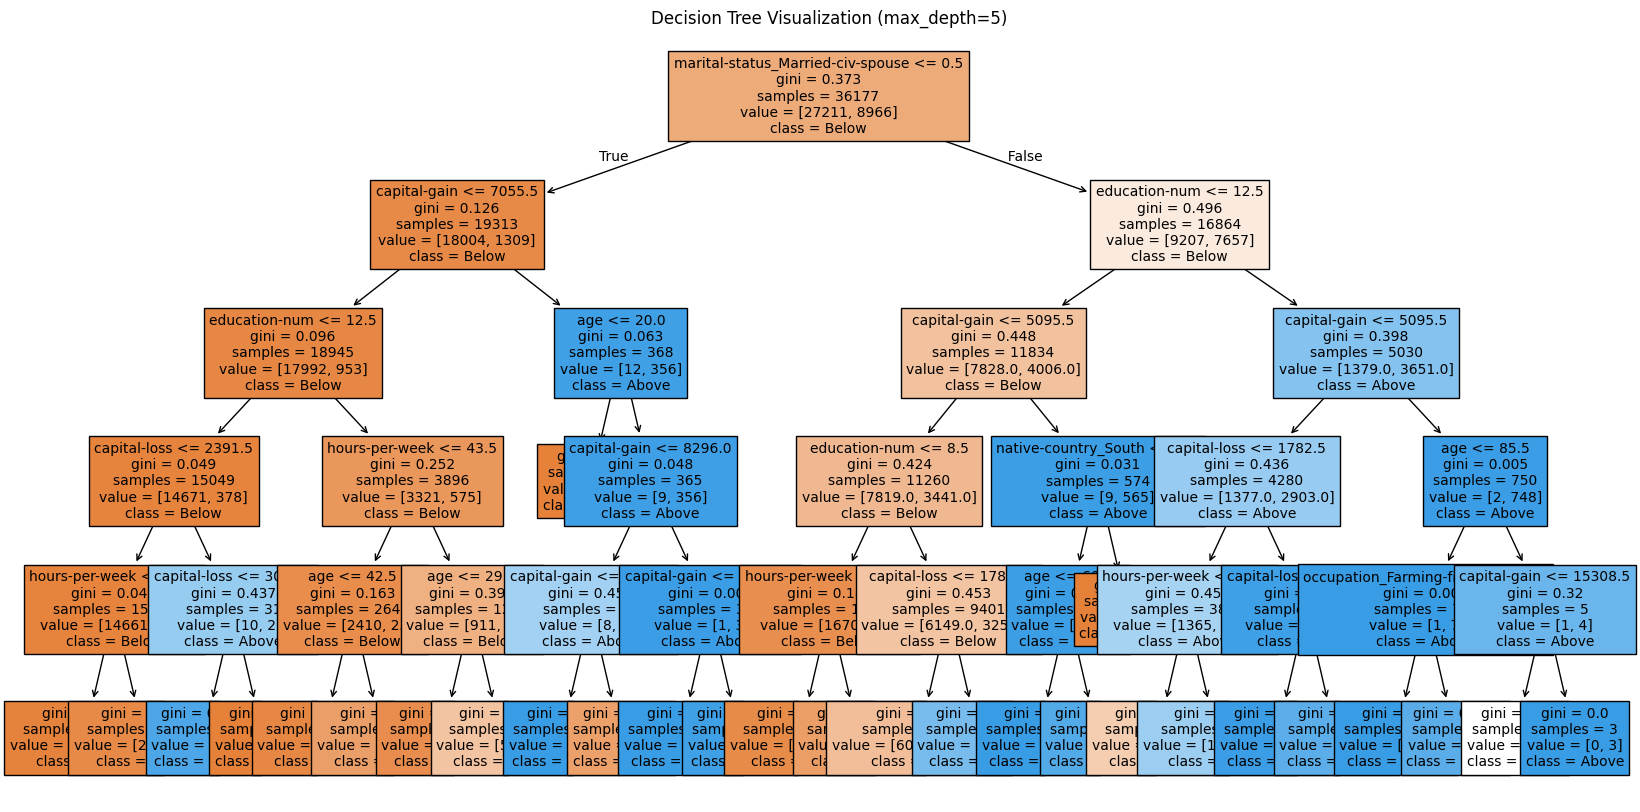

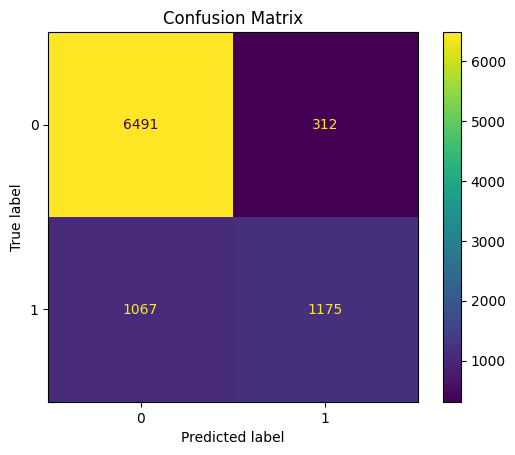

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score

def decision_tree_with_plots(X, y, max_depth=5):
    # stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=3001, stratify=y
    )

    # train with specified max_depth
    clf = DecisionTreeClassifier(random_state=3001, max_depth=max_depth)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    average_method = 'binary' if np.issubdtype(y_train.dtype, np.number) else 'macro'

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average_method, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average_method, zero_division=0)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")

    # tree
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        filled=True,
        feature_names=X.columns,
        class_names=['Below', 'Above'] if np.issubdtype(y_train.dtype, np.number) else None,
        max_depth=max_depth,
        fontsize=10
    )
    plt.title(f"Decision Tree Visualization (max_depth={max_depth})")
    plt.show()

    # confusion matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()

decision_tree_with_plots(X_clean, y_clean_binary, max_depth=5)

## **Question 3 (5 points):**
## Create a sorted list of feature importances and comment on the top features.Are there a few that seem to be more important than the others?

## Plot your feature importances in a horizontal or vertical bar chart from most to least important. Label each bar with its feature importance rounded to the nearest integer (ie: 30%).

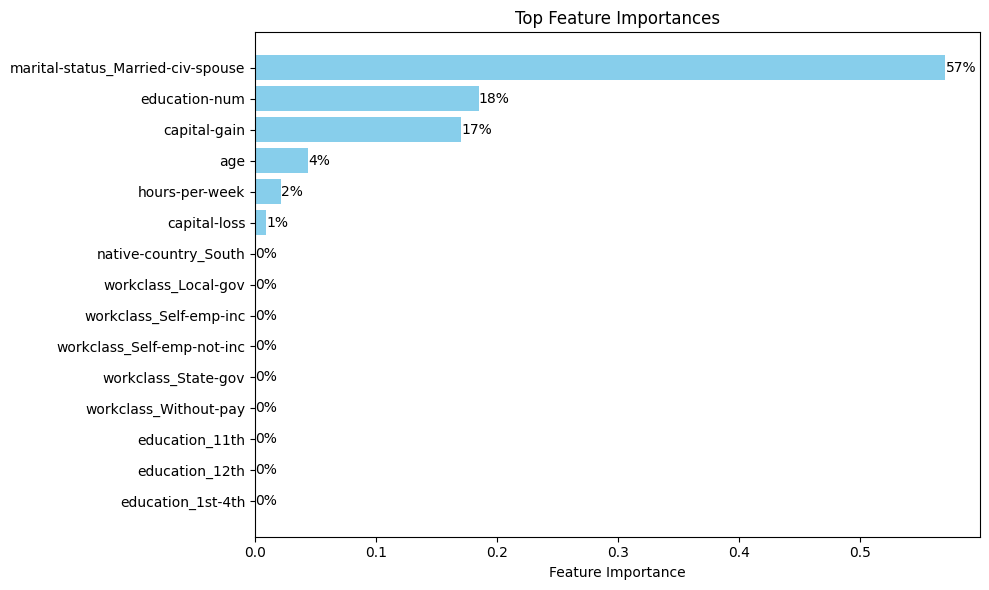

                              Feature  Importance
28  marital-status_Married-civ-spouse    0.570602
2                       education-num    0.184855
3                        capital-gain    0.170530
0                                 age    0.043729
5                      hours-per-week    0.021155
4                        capital-loss    0.008978
89               native-country_South    0.000150
6                 workclass_Local-gov    0.000000
8              workclass_Self-emp-inc    0.000000
9          workclass_Self-emp-not-inc    0.000000
10                workclass_State-gov    0.000000
11              workclass_Without-pay    0.000000
12                     education_11th    0.000000
13                     education_12th    0.000000
14                  education_1st-4th    0.000000


In [ ]:
def plot_feature_importances(model, X, top_n=None):
    importances = model.feature_importances_
    df_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    if top_n is not None:
        df_importance = df_importance.head(top_n)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(df_importance['Feature'], df_importance['Importance'], color='skyblue')
    plt.gca().invert_yaxis()  # largest on top
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(round(width * 100))}%',
                 va='center', ha='left', fontsize=10)
    plt.xlabel('Feature Importance')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()

    return df_importance

# train a decision tree for feature importance evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean_binary, test_size=0.2, random_state=3001, stratify=y_clean_binary
)
clf = DecisionTreeClassifier(random_state=3001, max_depth=5, class_weight='balanced')
clf.fit(X_train, y_train)

# plot the top 15 feature importances
print(plot_feature_importances(clf, X_clean, top_n=15))

Among all features, the most influential in the decision tree’s predictions is marital status, specifically whether someone is labeled as ‘Married-civ-spouse’, which accounts for a substantial 57% of the model’s decision-making. Other notable features include education-num, representing the individual’s education level, contributing around 18%, and capital-gain, which adds approximately 17%. Age plays a smaller role at 4%, while hours-per-week and capital-loss contribute even less. Many other features,such as specific workclass types and lower education levels, have negligible or no effect on the model’s predictions.

## **Question 4 (5 points):**
## Write at least 5 sentences interpreting the results of your decision tree, confusion matrix, and feature importance visualizations.

## Is there any aspect of your results that you are uncertain or unsure of?

**My results show...** The top levels of a decision tree are the most influential, since they’re where the model makes the biggest impurity-reducing splits. In this case, it’s clear that marital status, especially being labeled “Married-civ-spouse”, is the most impactful feature, followed closely by education level (education-num). Looking at the confusion matrix, the decision tree does a solid job predicting when someone makes $50,000 or less, as it misclassifies only 312 out of 6803, which is about a 4.8% error rate.

However, its performance drops when predicting who earns more than $50,000, with accuracy hovering around 50%, showing that higher income brackets are harder to predict and possibly influenced by more nuanced or variable factors. The feature importance plot backs this up. The marital status ‘Married-civ-spouse’ alone accounts for 57% of the decision-making power, which is striking. This status typically implies a stable household, which may correlate with higher, more stable income levels.

It’s also notable that capital-loss, which you’d think might be a useful indicator of financial instability or risk, contributes less than 1% to the decision. In contrast, capital-gain plays a much larger role. This suggests the model prioritizes financial growth signals over losses when predicting higher income.

## **Question 5 (5 points):**
## Finally, we will create a new function to tune your decision tree to get more accurate and efficient results. Update your function to take in several new parameters with these default values:
* criterion_val ='gini'
* splitter_val ='best'
* max_depth_val = None
* min_samples_split_val = 2
* min_samples_leaf_val =1

## Pass your own variable into the decision tree by specifying what sklearn parameter you are trying to tune. This will simply be the parameter without the "_val" suffix.

## **For example, if your vanilla decision tree variable is called clf, you would adjust it like this:**
`clf = DecisionTreeClassifier(criterion=criterion_val, splitter=splitter_val, ...)`

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def tune_decision_tree(X, y,
                       criterion_val='gini',
                       splitter_val='best',
                       max_depth_val=None,
                       min_samples_split_val=2,
                       min_samples_leaf_val=1,
                       top_n_features=15):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=3001, stratify=y
    )

    clf = DecisionTreeClassifier(
        criterion=criterion_val,
        splitter=splitter_val,
        max_depth=max_depth_val,
        min_samples_split=min_samples_split_val,
        min_samples_leaf=min_samples_leaf_val,
        random_state=3001
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    average_method = 'binary' if np.issubdtype(y_train.dtype, np.number) else 'macro'

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average_method, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average_method, zero_division=0)

    print(f"Criterion: {criterion_val}, Splitter: {splitter_val}, Max Depth: {max_depth_val}, "
          f"Min Samples Split: {min_samples_split_val}, Min Samples Leaf: {min_samples_leaf_val}")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")

    # tree
    plt.figure(figsize=(20, 10))
    plot_depth = max_depth_val if max_depth_val is not None else 5
    plot_tree(
        clf,
        filled=True,
        feature_names=X.columns,
        class_names=['Below', 'Above'] if np.issubdtype(y_train.dtype, np.number) else None,
        max_depth=plot_depth,
        fontsize=8
    )
    plt.title(f"Decision Tree Visualization (max_depth={plot_depth})")
    plt.show()

    # confusion matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()

    # feature importances
    importances = clf.feature_importances_
    feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feat_df = feat_df[feat_df['Importance'] > 0]
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(top_n_features)
    feat_df['Label'] = (feat_df['Importance'] * 100).round().astype(int).astype(str) + '%'

    plt.figure(figsize=(10, 6))
    bars = plt.barh(feat_df['Feature'], feat_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    for bar, label in zip(bars, feat_df['Label']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label,
                 va='center', ha='left', fontsize=9)
    plt.xlabel("Feature Importance")
    plt.title("Top Feature Importances")
    plt.tight_layout()
    plt.show()

    return clf

Criterion: gini, Splitter: best, Max Depth: 5, Min Samples Split: 2, Min Samples Leaf: 1
Accuracy: 0.848
Precision: 0.790
Recall: 0.524


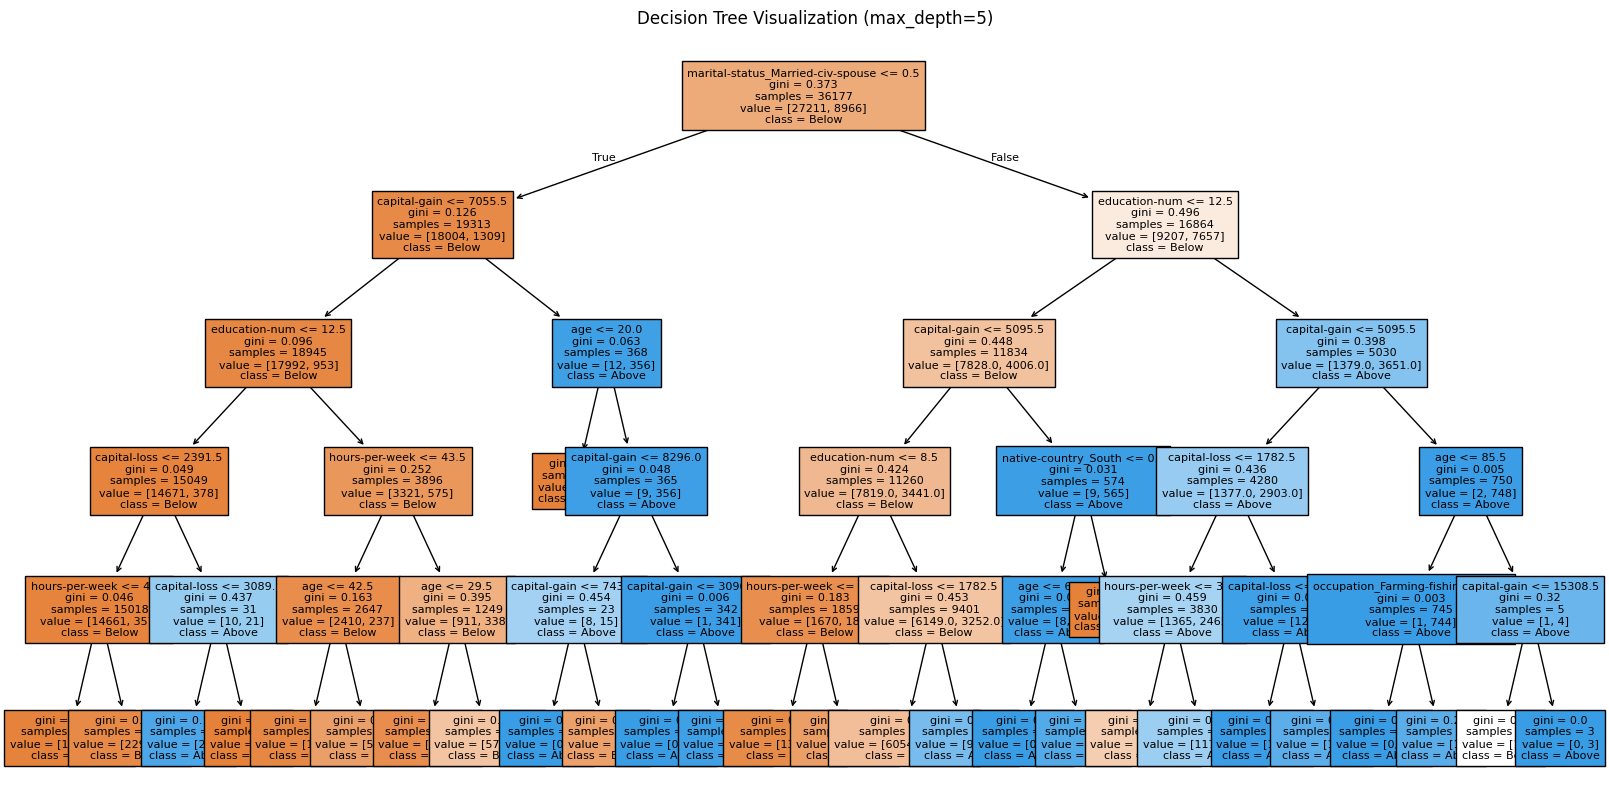

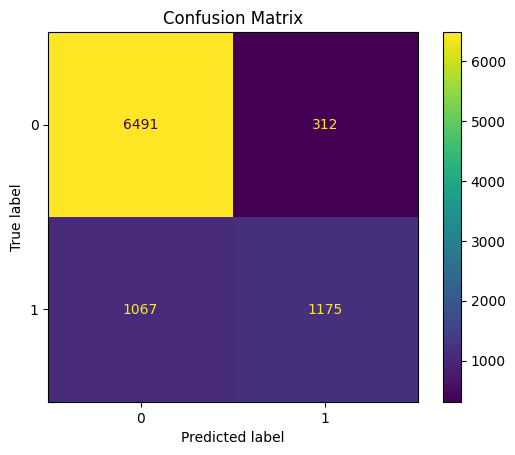

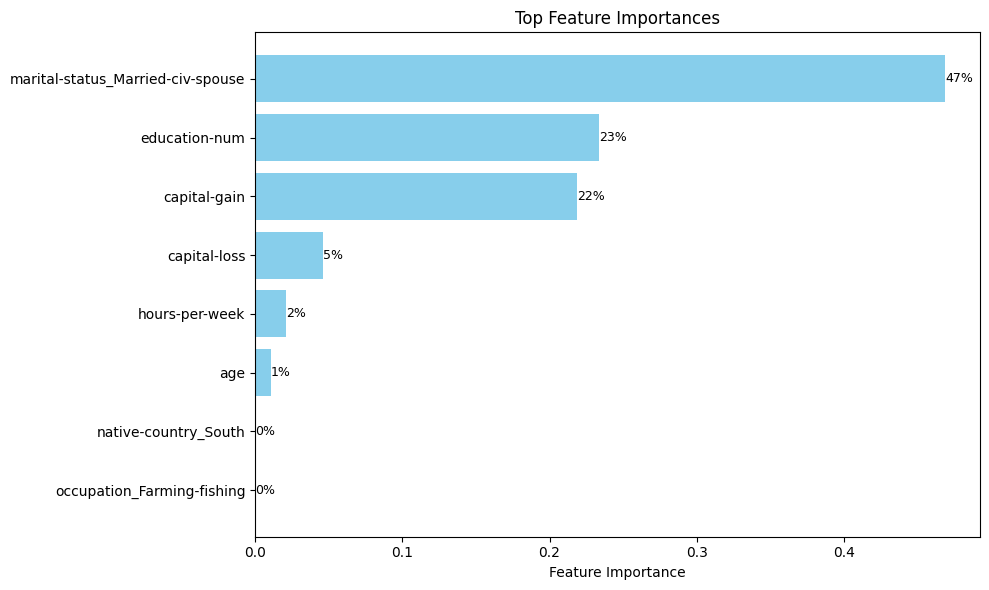

In [ ]:
model = tune_decision_tree(X_clean, y_clean_binary, max_depth_val=5)

## **Question 6 (5 points):**

## Call your new function with either clean y variable at least 3 times. Each time, vary the values for all the parameters and examine its effects on your tree, confusion matrix, and metrics.

## You will likely want to look at documentation to see accepted values:  
###https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Why did you pick the values you did? What combination had the best effect on accuracy? Were you surprised by any of the results?

Model 1: Shallow Tree with Conservative Splitting
Criterion: entropy, Splitter: best, Max Depth: 3, Min Samples Split: 10, Min Samples Leaf: 5
Accuracy: 0.840
Precision: 0.771
Recall: 0.506


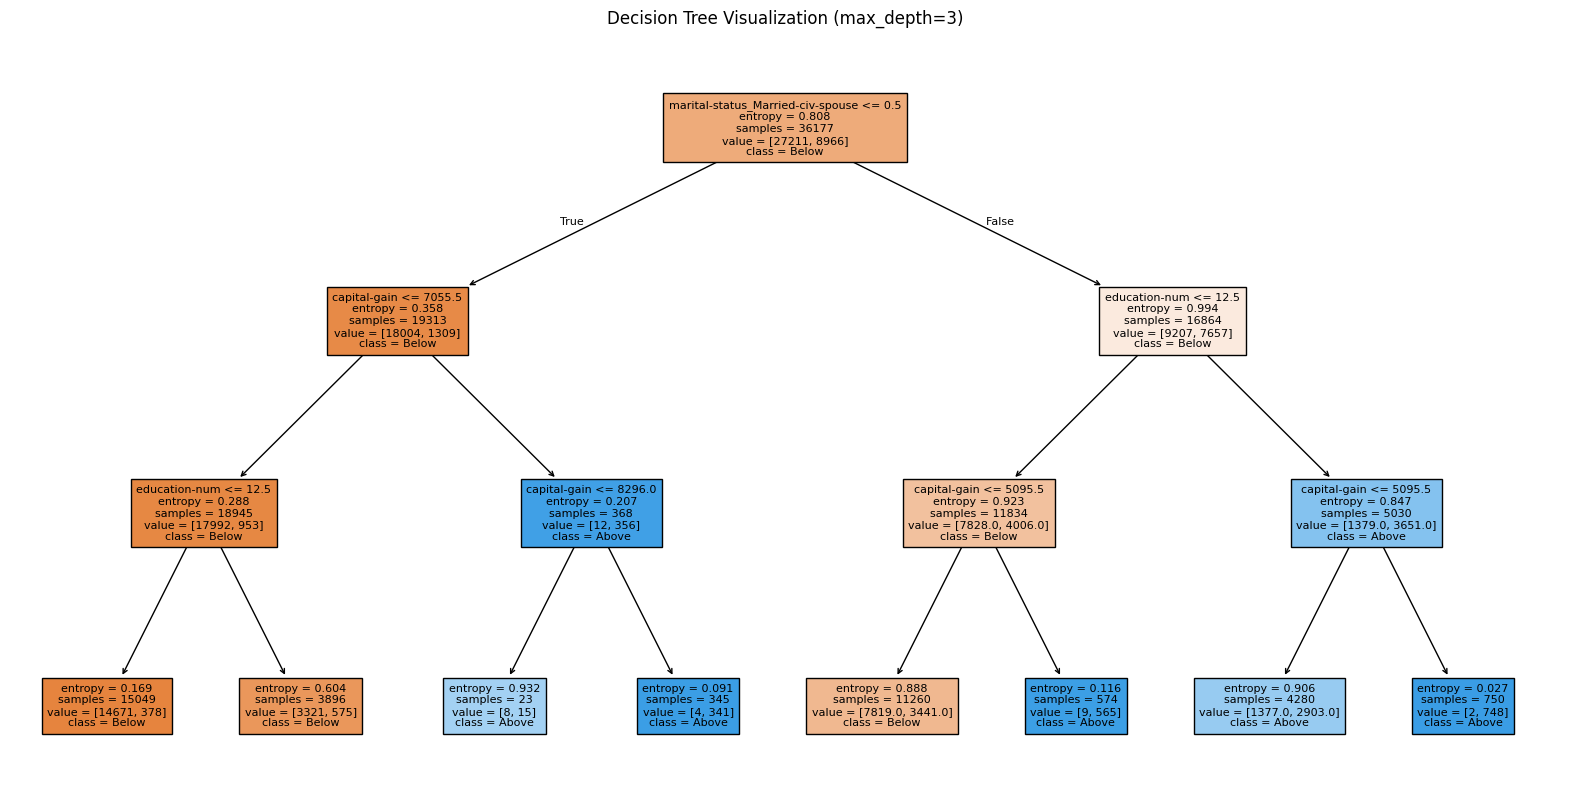

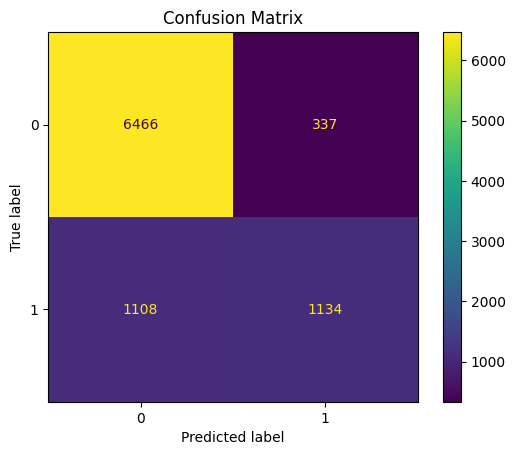

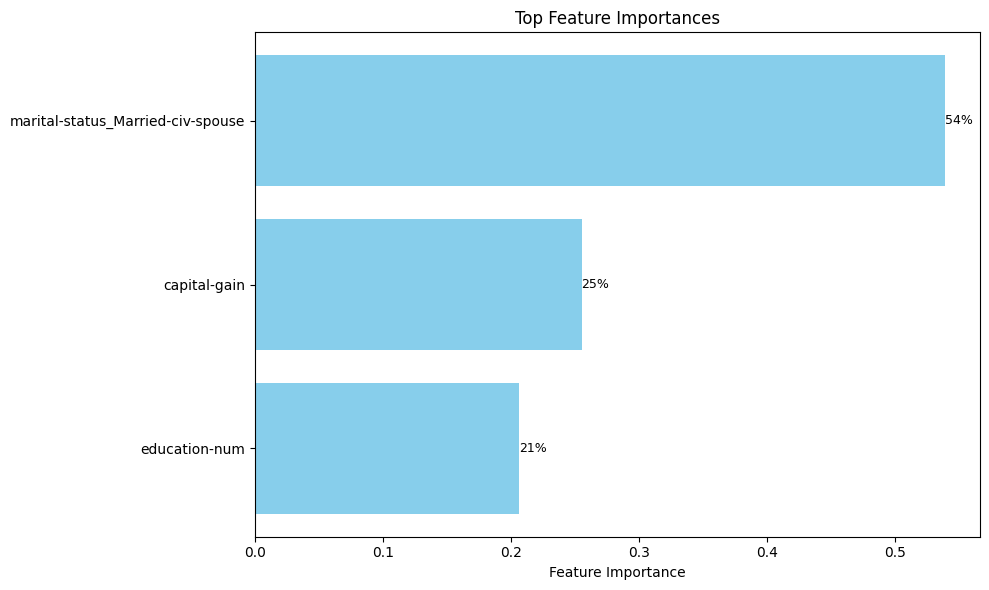

Model 2: Deeper Tree
Criterion: gini, Splitter: best, Max Depth: 10, Min Samples Split: 2, Min Samples Leaf: 1
Accuracy: 0.852
Precision: 0.765
Recall: 0.580


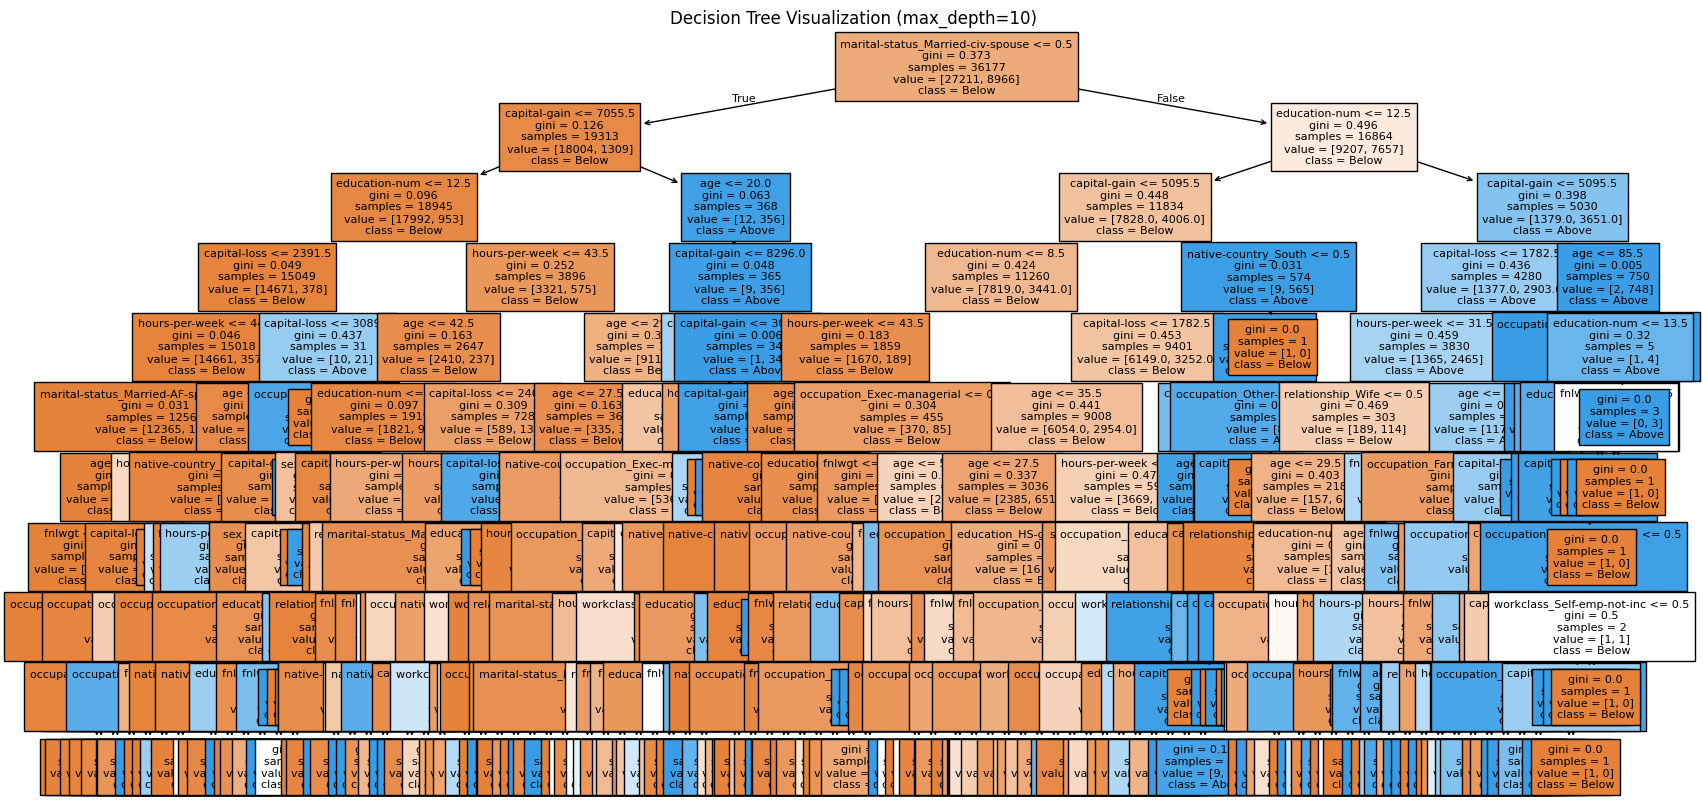

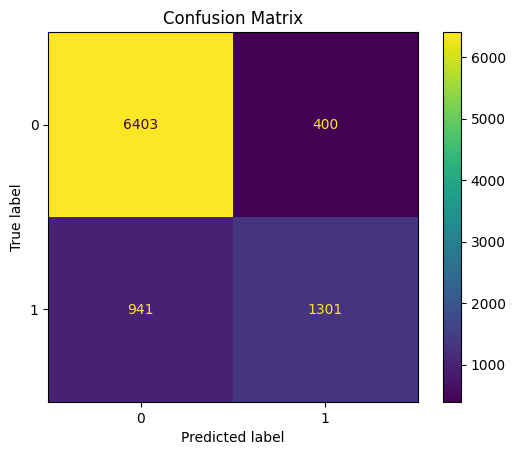

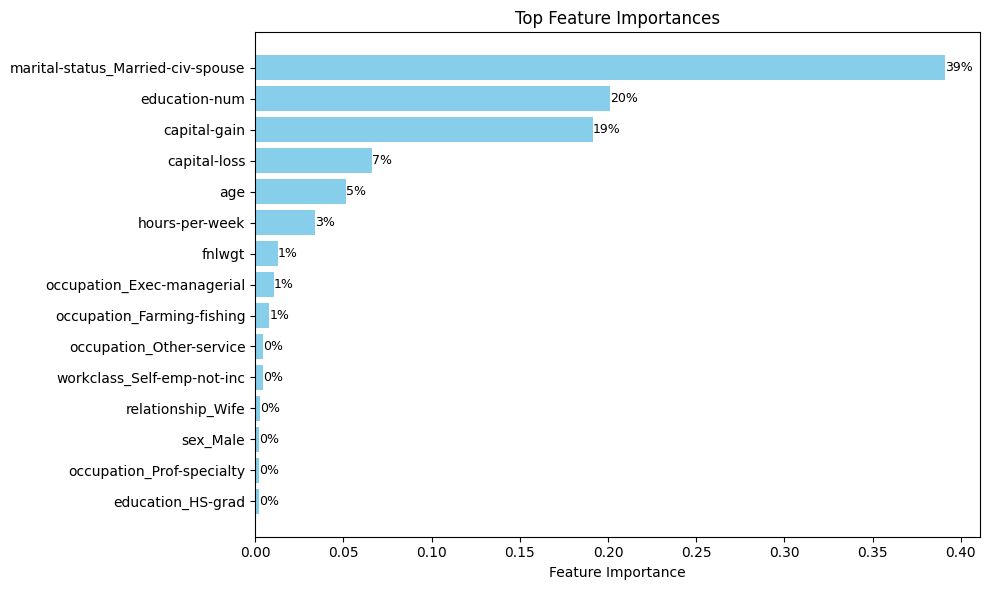

Model 3: Balanced Tree
Criterion: entropy, Splitter: best, Max Depth: 5, Min Samples Split: 5, Min Samples Leaf: 3
Accuracy: 0.841
Precision: 0.788
Recall: 0.492


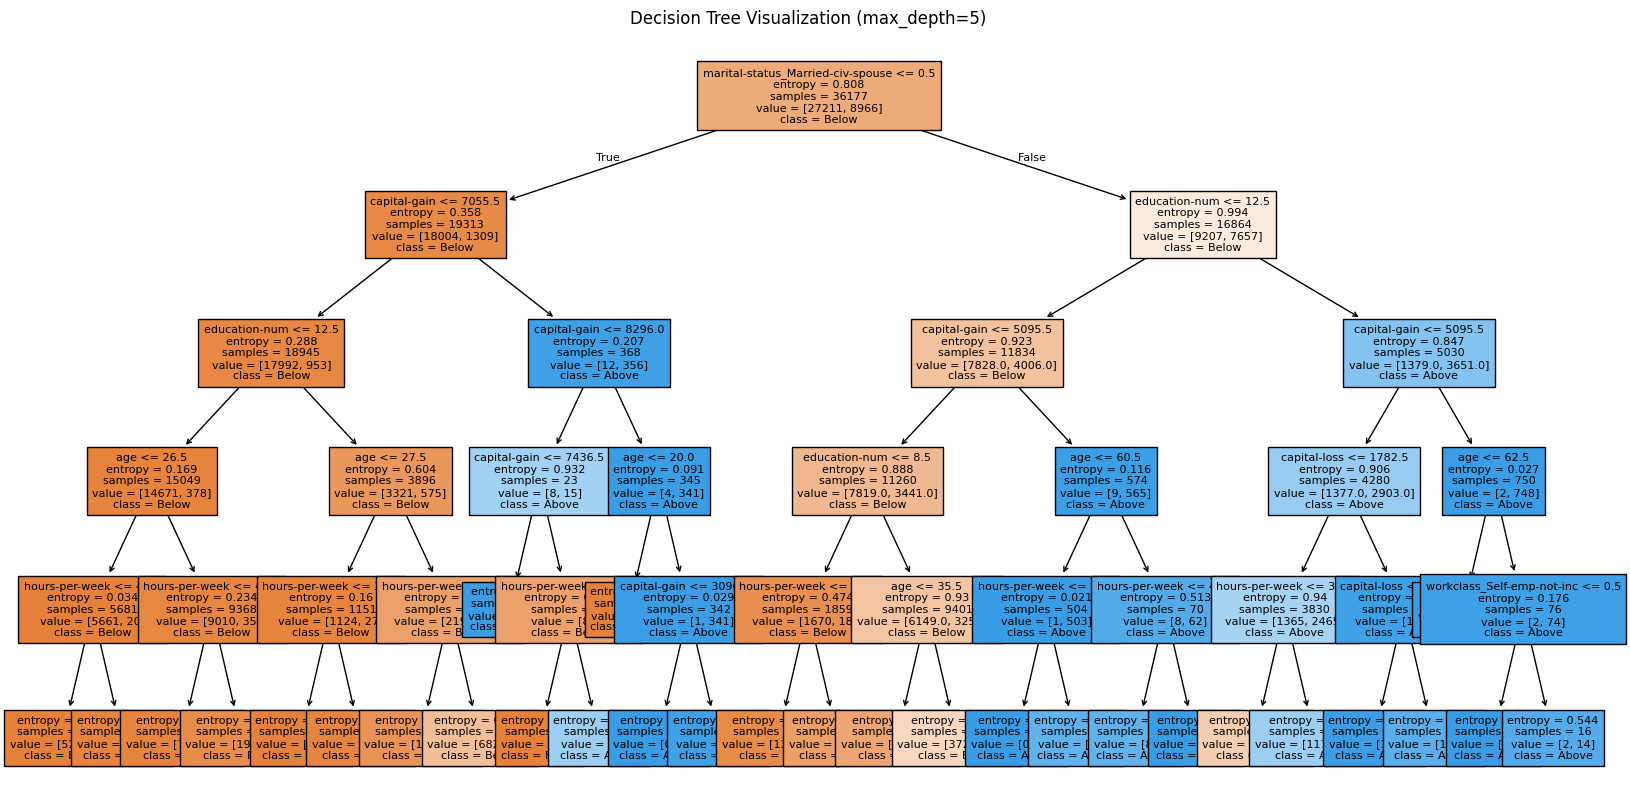

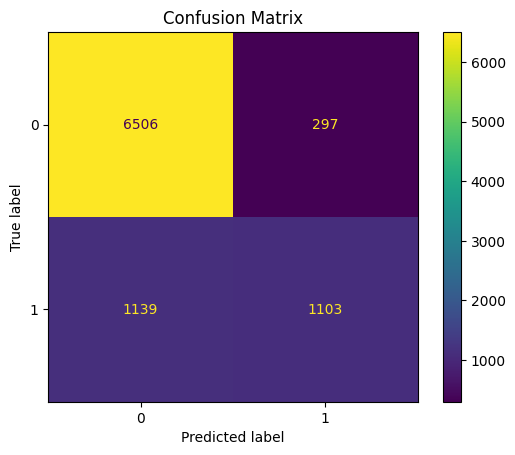

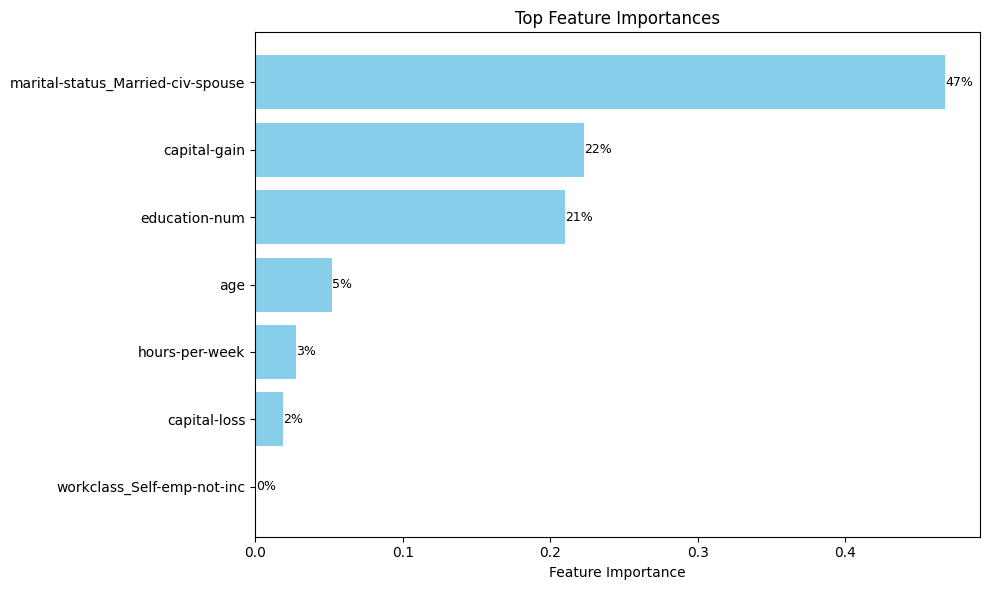

In [ ]:
# Model 1: shallow tree with conservative splitting
print("Model 1: Shallow Tree with Conservative Splitting")
model1 = tune_decision_tree(
    X_clean, y_clean_binary,
    criterion_val='entropy',
    splitter_val='best',
    max_depth_val=3,
    min_samples_split_val=10,
    min_samples_leaf_val=5
)

# Model 2: deeper tree
print("Model 2: Deeper Tree")
model2 = tune_decision_tree(
    X_clean, y_clean_binary,
    criterion_val='gini',
    splitter_val='best',
    max_depth_val=10,
    min_samples_split_val=2,
    min_samples_leaf_val=1
)

# Model 3: balanced tree
print("Model 3: Balanced Tree")
model3 = tune_decision_tree(
    X_clean, y_clean_binary,
    criterion_val='entropy',
    splitter_val='best',
    max_depth_val=5,
    min_samples_split_val=5,
    min_samples_leaf_val=3
)

When looking at these three models to try different levels of complexity and see how they affect the results. For Model 1, I kept the tree shallow and added more limits to avoid overfitting. It had an accuracy of 84.0 percent and a recall of 50.6 percent. Model 2 had fewer limits and a deeper tree, which led to the highest accuracy at 85.2 percent and a higher recall of 58.0 percent. Model 3 was a mix of the two, with accuracy similar to Model 1 at 84.1 percent and the highest precision at 78.8 percent, but it had the lowest recall at 49.2 percent. These results show how changing settings like tree depth and split size can affect whether the model is better at catching more high-income predictions (recall) or making fewer mistakes when it predicts someone earns more (precision).

# **Part 3: Random Forest and Ensembling Evaluation (40 Points)**

## For Parts 3 and 4, you may pick *your own dataset* or continue with the census data.

## Like above, you will want to reference the documentation as necessary:
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


## **Data**
## Use this space to load and call your data for Parts 3 and 4. You are welcome to use your final project data for these sections.

In [ ]:
 # used the census data

## **Question 1 (10 points):**

## Write a function to take in a feature variable (X) and a target variable (y). Create a train test split for the variables.

## Finally, instantiate, fit, and predict using **both** a single Decision Tree and a Random Forest classifier. Print the accuracy, precision, and recall for both models.

## Call your function and describe your baseline results.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

def tree_and_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=3001, stratify=y
    )
    average_method = 'binary' if np.issubdtype(y.dtype, np.number) else 'macro'


    tree = DecisionTreeClassifier(random_state=3001)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)

    tree_prec = precision_score(y_test, y_pred_tree, average=average_method, zero_division=0)
    tree_rec = recall_score(y_test, y_pred_tree, average=average_method, zero_division=0)
    tree_acc = accuracy_score(y_test, y_pred_tree)

    forest = RandomForestClassifier(random_state=3001)
    forest.fit(X_train, y_train)
    y_pred_forest = forest.predict(X_test)

    forest_prec = precision_score(y_test, y_pred_forest, average=average_method, zero_division=0)
    forest_rec = recall_score(y_test, y_pred_forest, average=average_method, zero_division=0)
    forest_acc = accuracy_score(y_test, y_pred_forest)

    print(f"Decision Tree Precision: {tree_prec:.4f}")
    print(f"Decision Tree Recall: {tree_rec:.4f}")
    print(f"Decision Tree Accuracy: {tree_acc:.4f}")

    print(f"Random Forest Precision: {forest_prec:.4f}")
    print(f"Random Forest Recall: {forest_rec:.4f}")
    print(f"Random Forest Accuracy: {forest_acc:.4f}")

tree_and_forest(X_clean, y_clean_binary)

Decision Tree Precision: 0.6021
Decision Tree Recall: 0.6142
Decision Tree Accuracy: 0.8038
Random Forest Precision: 0.7255
Random Forest Recall: 0.6084
Random Forest Accuracy: 0.8459


From the baseline results, the Random Forest model outperforms the single Decision Tree. The Random Forest reached an accuracy of 84.6%, compared to the Decision Tree’s 80.4%. It also had higher precision at 72.6% versus 60.2%, which means it was better at correctly identifying people who actually earn more than $50K when it predicted they did. Interestingly, the recall was about the same for both models, 61.4% for the Decision Tree and 60.8% for the Random Forest, showing they were equally good at catching actual high earners. The improvement in precision and accuracy comes from how Random Forests work: they build many decision trees on different parts of the data and average their predictions. This helps reduce overfitting and makes the model more stable when faced with new data. Overall, the Random Forest shows better performance across the board.


## **Question 2 (30 points):**
## This question will ask you to tune Random Forest classifiers and preprocess your data in *any number of ways* to achieve the *best possible results you can*.

## Train one vanilla Decision Forest model and one vanilla Random Forest model and store their accuracies in variables so you can use them as baselines.

## Then, using functions or not, spend some time tuning at least 10 (or more) Random Forest models. Store your accuracies in a list or array and print your maximum accuracy.

# **Go crazy - feel free to implement sampling, dropping features, preprocessing, new parameters, whatever might boost your accuracy.**

# **The top 5 best accuracies in the class will get +15 on their individual lab grade!**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean_binary, test_size=0.2, random_state=3001, stratify=y_clean_binary)

# vanilla tree
vanilla_tree = DecisionTreeClassifier(random_state=3001)
vanilla_tree.fit(X_train, y_train)
y_pred_tree = vanilla_tree.predict(X_test)
baseline_tree_acc = accuracy_score(y_test, y_pred_tree)
print(f"Baseline Decision Tree Accuracy: {baseline_tree_acc:.4f}")

# vanilla random forest
vanilla_rf = RandomForestClassifier(random_state=3001)
vanilla_rf.fit(X_train, y_train)
y_pred_rf = vanilla_rf.predict(X_test)
baseline_rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Baseline Random Forest Accuracy: {baseline_rf_acc:.4f}")

Baseline Decision Tree Accuracy: 0.8038
Baseline Random Forest Accuracy: 0.8459


In [ ]:
import random
import sys
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean_binary,
    test_size=0.2,
    random_state=3001,
    stratify=y_clean_binary
)

def sample_params():
    return {
        'n_estimators': random.randint(100, 200),
        'max_depth': random.choice([None, 10, 20]),
        'min_samples_split': random.randint(2, 8),
        'min_samples_leaf': random.randint(1, 5),
        'max_features': random.choice(['sqrt', 'log2']),
        'bootstrap': True,
        'class_weight': random.choice([None, 'balanced'])
    }

# manually run random search
n_iter = 60
best_score = -1
best_params = None

search_results = []

for i in range(n_iter):
    params = sample_params()

    rf = RandomForestClassifier(random_state=3001, **params)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    search_results.append((i+1, params, acc))

    if acc > best_score:
        best_score = acc
        best_params = params

print(f"Best Score: {best_score:.4f}")
print("Best Params:", best_params)

print("\nAll results:")
for i, prm, ac in search_results:
    print(f"Iteration {i}: Accuracy = {ac:.4f}, Params = {prm}")

Best Score: 0.8600
Best Params: {'n_estimators': 113, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}

All results:
Iteration 1: Accuracy = 0.8542, Params = {'n_estimators': 196, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}
Iteration 2: Accuracy = 0.8583, Params = {'n_estimators': 105, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}
Iteration 3: Accuracy = 0.8552, Params = {'n_estimators': 115, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}
Iteration 4: Accuracy = 0.8574, Params = {'n_estimators': 142, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}
Iteration 5: Accuracy = 0.857

# **Part 4: Ensemble Model Interpretation and Reflection (15 Points)**


## **Question 1 (5 points):**
## Create a plot that summarizes the results of your experiments and how they compare to the results of your baseline Decision Tree and Random Forest model.

## You may visualize your results in any type of plot you see fit. Color code your visual in some way so that models that did better than the baseline Random Forest are distinguished from models that did worse.

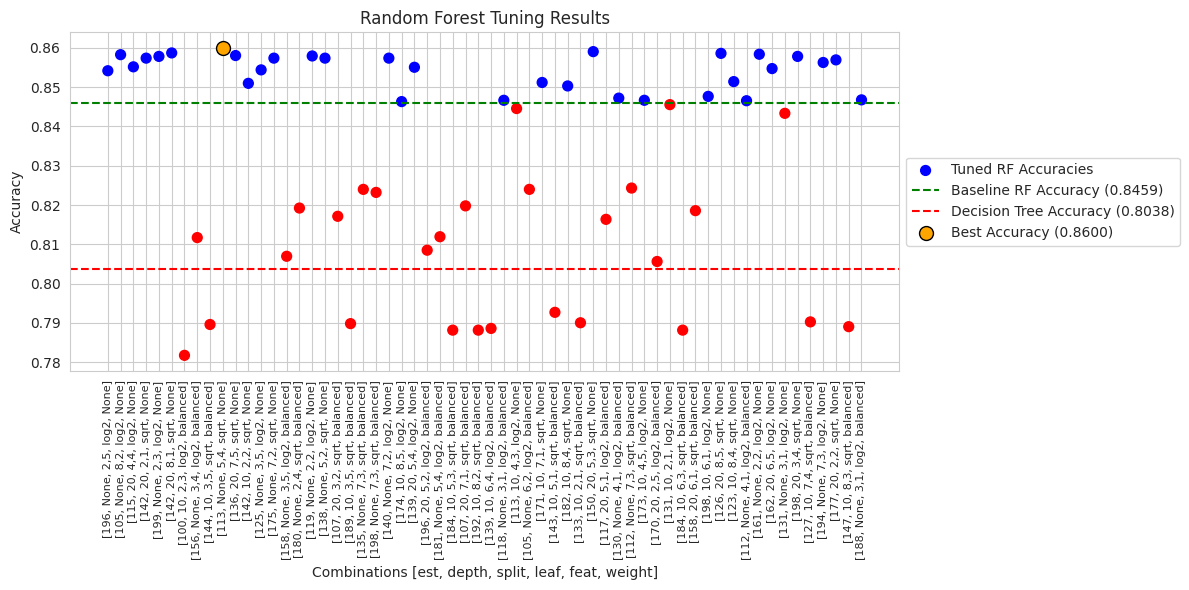

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

iterations = []
params_str_list = []
accuracies = []
for i, prm, acc in search_results:
    iterations.append(i)
    params_str = (f"[{prm['n_estimators']}, {prm['max_depth']}, "
                  f"{prm['min_samples_split']},{prm['min_samples_leaf']}, "
                  f"{prm['max_features']}, {prm['class_weight']}]")
    params_str_list.append(params_str)
    accuracies.append(acc)

best_acc = max(accuracies)
best_index = accuracies.index(best_acc)
best_params_label = params_str_list[best_index]
colors = ['red' if acc < baseline_rf_acc else 'blue' for acc in accuracies]
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

plt.scatter(range(len(accuracies)), accuracies, c=colors, s=50, label="Tuned RF Accuracies")
plt.axhline(y=baseline_rf_acc, color='green', linestyle='--', label=f"Baseline RF Accuracy ({baseline_rf_acc:.4f})")
plt.axhline(y=baseline_tree_acc, color='red', linestyle='--', label=f"Decision Tree Accuracy ({baseline_tree_acc:.4f})")
plt.scatter(best_index, best_acc, color='orange', s=100, edgecolor='black', label=f"Best Accuracy ({best_acc:.4f})")
plt.xticks(ticks=range(len(params_str_list)), labels=params_str_list, rotation=90, fontsize=8)

plt.xlabel("Combinations [est, depth, split, leaf, feat, weight]")
plt.ylabel("Accuracy")
plt.title("Random Forest Tuning Results")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## **Question 2 (5 points):**
## Write 10 or more sentences on what parameters had the biggest effect or did not seem to effect your results. Did any parameter choices make your results worse than your vanilla model?

**The parameters I chose...**

After tuning and comparing results, one clear takeaway is that the number of estimators didn’t have a major effect on model performance. Whether a Random Forest had 100 or 200 trees, the accuracy stayed fairly consistent, suggesting that more trees didn’t uncover new patterns. In contrast, parameters like tree depth, minimum samples to split, and minimum samples in a leaf had a much bigger impact. These settings control how complex the trees can grow, and adjusting them clearly influenced how well the model generalized to new data. The best-performing models typically had no depth limit and slightly stricter requirements for splits and leaves, helping reduce overfitting. A few models with very relaxed settings, like no max depth and only one sample needed to split, performed about the same as the vanilla Random Forest, likely because they learned similar patterns. Only one model performed noticeably worse, and the biggest difference was that it had just 50 estimators, reducing variance and generalization. Interestingly, class_weight=‘balanced’ didn’t help in this dataset; in fact, models with this setting usually performed worse. This might be because the cleaned data was already fairly balanced. Overall, only some of the tuned Random Forest models performed worse than the baseline Decision Tree, which reinforces how effective ensemble methods are for classification tasks.

## **Question 3 (5 points):**
## Write 10 or more sentences reflecting on the tuning process.

## What kind of approach did you take? Was it random combinations or more structured? Did you change your approach after seeing your initial results?

## What kind of strategies in preprocessing and picking parameters (ie: brute forcing parameters, testing various values in a range) do you think would get some of the best scores in the class?

**My approach to tuning...**

When tuning the model, I used a randomized search approach rather than a structured grid search. I created a function that randomly sampled values for key Random Forest parameters like the number of estimators, max depth, minimum samples to split, and minimum samples per leaf. Instead of trying every combination in a fixed grid, I let the model explore a wide space of parameter combinations in a more flexible and time-efficient way. This allowed me to quickly identify which types of configurations performed better without needing to test all possibilities. As I reviewed the results from each iteration, I noticed trends in what worked. For example, deeper trees with no max depth combined with moderate split and leaf requirements often performed best. I didn’t change the core structure of my approach, but I did tweak the ranges and parameter values being sampled as I gathered more insight from earlier iterations. I kept the preprocessing from the earlier part of the lab, which included dropping missing values and using one-hot encoding for categorical features. I chose not to drop any features or do additional feature engineering since performance was already strong across most configurations. Overall, I think this kind of randomized tuning strategy is effective because it balances exploration with efficiency, and it allows for discovering unexpectedly strong combinations that might be missed in a strict grid search. For future improvements, combining this with some smarter pruning of weak features or adjusting sampling strategies could push performance even higher.

### Honor Pledge

On my honor as a student, I have neither given nor received unauthorized aid on this assignment.